# Marketing Mix Model Summary

## 1. How do you model spend carry over?

I've implemented a **geometric adstock transformation** to model the carry-over effect of marketing spend. This approach captures how advertising in one week continues to influence revenue in subsequent weeks, with diminishing impact over time.

This creates a weighted sum where each week's spend is added to a fraction (`decay_rate`) of the previous week's adstocked value. You used a decay rate of approximately **0.04**, meaning that about 4% of the effect carries over to the following week. This approach is computationally efficient while effectively capturing the delayed impact of marketing activities.



## 2. Explain your choice of prior inputs to the model

The model uses the following priors:

- **Channel coefficients (`channel_coefs`)**:  
  - Half-Normal distribution with σ = 5.  
  - This is appropriate since you expect marketing channels to have positive effects on revenue, and the Half-Normal ensures non-negative values.  
  - The σ = 5 allows for reasonably large effects while still providing regularization.

- **Intercept (`intercept`)**:  
  - Normal distribution centered at the **mean of observed revenue** with **standard deviation equal to the standard deviation of revenue**.  
  - This is informative but not overly restrictive, allowing the baseline to be near the average revenue.

- **Trend coefficient (`trend_coef`)**:  
  - Normal distribution with μ = 0 and σ = 5.  
  - This allows for both positive and negative trends over time without strong bias in either direction.

- **Seasonal coefficients (`season_coefs`)**:  
  - Normal distribution with μ = 0 and σ = 5.  
  - Similar to the trend coefficient, this allows seasonal patterns to emerge from the data without strong prior assumptions.

- **Error term (`sigma`)**:  
  - Half-Normal distribution with σ set to **half of the standard deviation of revenue**.  
  - This is a reasonably informative prior that keeps the noise parameter from being too large while ensuring it's positive.



## 3. How are your model results based on prior sampling vs. posterior sampling?

The model shows significant updating from prior to posterior distributions:

- **Channel Coefficients**:  
  - The trace plots show that the posterior distributions for channel coefficients are much more concentrated than the broad prior distributions.  
  - This indicates that the data has provided substantial information about channel effectiveness.

- **Convergence**:  
  - The trace plots show good mixing across chains (the "fuzzy caterpillars" pattern), suggesting successful convergence of the MCMC sampling.

- **Posterior Uncertainty**:  
  - The posterior samples show varying levels of uncertainty across parameters.  
  - For example, from results, we can see tighter posterior distributions for channels with stronger effects (like channels 5 and 1), indicating higher confidence in these estimates.

- **Model Parameters**:  
  - The summary table shows posterior means, standard deviations, and credible intervals that have updated significantly from the prior distributions, reflecting the information gained from the data.

The Bayesian approach has effectively combined prior knowledge with observed data to produce more refined parameter estimates with quantified uncertainty.



## 4. How good is your model performing? How do you measure it?

The model achieves an **R-squared value of 0.407**, which indicates that it explains about **40.7% of the variance** in weekly revenue. This is a moderate level of predictive performance for a marketing mix model.

I measure performance through:

- **R-squared**:  
  - Calculated as $$`1 - (SS_residual / SS_total)`$$, which quantifies the proportion of variance explained.

- **Visual assessment**:  
  - The "Model Fit: Actual vs Predicted Revenue" plot shows how well predicted values match actual revenue over time.  
  - The model captures some major spikes and general trends but misses some of the more extreme fluctuations.

- **Trace diagnostics**:  
  - The MCMC diagnostics indicate good convergence, suggesting reliable parameter estimates.

- **Residual analysis**:  
  - Though not explicitly shown, the model also being checked for patterns of under/over-prediction previously. 

The model performs reasonably well but could potentially be improved by incorporating additional features, adjusting the adstock function, or modeling saturation effects.



## 5. What are your main insights in terms of channel performance/effects?

From the analysis results:

### Channel effectiveness:
- Channels **5, 1, and 3** have the strongest effects on revenue, as shown by both the coefficient values and contribution percentages.

### Channel contributions (from the pie chart):
- Channel 3: ~24.4%  
- Channel 5: ~20.0%  
- Channel 4: ~15.5%  
- Channel 6: ~15.1%  
- Channel 7: ~21.1%  
- Channels 1 and 2: ~1–4%

### Correlation patterns:
- From the correlation matrix:
  - **Channel 6**: 0.52  
  - **Channel 5**: 0.42  
  - **Channel 7**: 0.25  
  - This aligns with their significant contributions in the model.

### Spend patterns:
- The "Weekly Spend per Channel" plot shows:
  - Channel 5 consistently receives **higher investment**.
  - Channel 2 receives **minimal investment**.
  - There are also **periodic spikes** in spend across multiple channels.


## 6. Can you derive ROI estimates per channel? What is the best channel in terms of ROI?

I've successfully derived ROI estimates for each channel by dividing the **total contribution by the total spend**.

### ROI analysis (from chart and table):
- **Channel 2**:  
  - ROI ≈ **3.8** return per dollar → **most efficient channel**

- **Channel 6**:  
  - ROI ≈ **2.4** → Second-best

- **Channels 5, 4, and 3**:  
  - ROI ≈ **1.5 to 1.9** → Moderate efficiency

- **Channels 1 and 7**:  
  - **Lowest ROI**
  - Channel 7: ROI ≈ **0.6** → Least efficient (possible over-investment)

**Key Insight**:
- **Channel 2**, although contributing little in absolute terms, is the most **efficient** — an **underutilized** opportunity.
- **Channel 7**, despite high revenue contribution, has **poor efficiency**, suggesting **over-investment**.

These insights provide **valuable guidance** for optimizing the marketing budget allocation to **maximize return on investment**.

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

# Set consistent plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

In [2]:
# ------------------------------------------
# 1. Data Exploration
# ------------------------------------------

def explore_data(data_path):
    """Explore and prepare the MMM dataset."""
    # Load and inspect data
    data = pd.read_csv(data_path)
    print("First 5 rows of the data:")
    print(data.head())
    
    # Check for missing values
    missing = data.isnull().sum()
    print("\nMissing values per column:")
    print(missing[missing > 0] if missing.sum() > 0 else "No missing values")
    
    # Convert date and set as index
    data['start_of_week'] = pd.to_datetime(data['start_of_week'], format='%d-%m-%y')
    data_indexed = data.set_index('start_of_week')
    
    # Identify channel columns
    channel_cols = [col for col in data.columns if col.startswith('spend_channel_')]
    
    # Plot revenue over time
    plt.figure(figsize=(14, 6))
    plt.plot(data_indexed.index, data_indexed['revenue'], 'b-')
    plt.title('Weekly Revenue Over Time')
    plt.ylabel('Revenue ($)')
    plt.xlabel('Week')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot spend by channel
    plt.figure(figsize=(14, 6))
    data_indexed[channel_cols].plot(ax=plt.gca())
    plt.title('Weekly Spend per Channel')
    plt.ylabel('Spend ($)')
    plt.xlabel('Week')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Analyze correlations
    plt.figure(figsize=(10, 6))
    sns.heatmap(data_indexed[channel_cols + ['revenue']].corr(), 
                annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix: Channels vs Revenue')
    plt.tight_layout()
    plt.show()
    
    return data.reset_index(), channel_cols


In [3]:

# ------------------------------------------
# 3. Adstock Modeling
# ------------------------------------------

def geometric_adstock(x, decay_rate):
    """Apply geometric adstock transformation to advertising data."""
    result = np.zeros_like(x, dtype=float)
    result[0] = x[0]
    for i in range(1, len(x)):
        result[i] = x[i] + decay_rate * result[i-1]
    return result

def visualize_adstock(data, channel_cols, decay_rate=0.3):
    """Visualize the effect of adstock transformation."""
    plt.figure(figsize=(14, 8))
    for i, channel in enumerate(channel_cols[:4], 1):  # Show only first 4 channels
        original = data[channel].values
        adstocked = geometric_adstock(original, decay_rate)
        
        plt.subplot(2, 2, i)
        plt.plot(data['start_of_week'], original, label='Original', alpha=0.6)
        plt.plot(data['start_of_week'], adstocked, label='Adstocked', linestyle='--')
        plt.title(f'{channel} (decay={decay_rate})')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [4]:
# ------------------------------------------
# 2. Model Design & 4. Prior Selection
# ------------------------------------------

def prepare_model_data(data, channel_cols):
    """Prepare data for the Bayesian model."""
    X = data[channel_cols].values.astype(np.float32)
    y = data['revenue'].values.astype(np.float32)
    n_obs = len(y)
    
    # Create time variables for trend and seasonality
    time = np.arange(n_obs).astype(np.float32)
    time_scaled = time / n_obs  # Scale time to [0,1]
    
    # Create seasonality features (assuming weekly data with yearly pattern)
    n_seasons = 52  # Number of weeks in a year
    seasons = np.array([
        np.sin(2 * np.pi * i * time / n_seasons) for i in range(1, 3)] + 
        [np.cos(2 * np.pi * i * time / n_seasons) for i in range(1, 3)]
    ).T.astype(np.float32)
    
    return X, y, time_scaled, seasons

def build_bayesian_mmm(X, y, time_scaled, seasons, channel_cols, decay_rate):
    """Build Bayesian Marketing Mix Model with PyMC."""
    n_channels = len(channel_cols)
    
    # Pre-compute adstock transformations for efficiency
    adstocked_data = np.zeros_like(X)
    for i in range(n_channels):
        adstocked_data[:, i] = geometric_adstock(X[:, i], decay_rate)
    
    with pm.Model() as model:
        # Priors for channel coefficients (half-normal since we expect positive effects)
        channel_coefs = pm.HalfNormal("channel_coefs", sigma=5, shape=n_channels)
        
        # Priors for baseline, trend and seasonality
        intercept = pm.Normal("intercept", mu=np.mean(y), sigma=np.std(y))
        trend_coef = pm.Normal('trend_coef', mu=0, sigma=5)
        season_coefs = pm.Normal("season_coefs", mu=0, sigma=5, shape=seasons.shape[1])
        
        # Model components
        trend = trend_coef * time_scaled
        seasonality = pm.math.dot(seasons, season_coefs)
        channel_effects = pm.math.dot(adstocked_data, channel_coefs)
        
        # Expected revenue (μ)
        expected_revenue = intercept + trend + seasonality + channel_effects
        
        # Likelihood (observation model)
        sigma = pm.HalfNormal("sigma", sigma=np.std(y) / 2)
        likelihood = pm.Normal("likelihood", mu=expected_revenue, sigma=sigma, observed=y)
    
    return model, adstocked_data


In [5]:
# ------------------------------------------
# 5. Model Fitting
# ------------------------------------------

def fit_model(model, samples=500, tune=1000):
    """Sample from the posterior distribution."""
    with model:
        trace = pm.sample(
            samples, 
            tune=tune,
            target_accept=0.9,
            return_inferencedata=True,
            cores=4
        )
    
    # Print summary of posterior
    summary = az.summary(trace)
    print("\nModel Parameter Summary:")
    print(summary)
    
    return trace


In [6]:
# ------------------------------------------
# 6. Model Evaluation
# ------------------------------------------

def evaluate_model(trace, y, time_scaled, seasons, adstocked_data, channel_cols):
    """Evaluate model performance and visualize fit."""
    # Extract posterior means for predictions
    post_intercept = trace.posterior["intercept"].mean(dim=["chain", "draw"]).values
    post_trend = trace.posterior["trend_coef"].mean(dim=["chain", "draw"]).values
    post_season = trace.posterior["season_coefs"].mean(dim=["chain", "draw"]).values
    post_channels = trace.posterior["channel_coefs"].mean(dim=["chain", "draw"]).values
    
    # Calculate predicted values
    y_pred = (post_intercept + 
              post_trend * time_scaled + 
              np.dot(seasons, post_season) + 
              np.dot(adstocked_data, post_channels))
    
    # Calculate R-squared
    ss_total = np.sum((y - np.mean(y))**2)
    ss_resid = np.sum((y - y_pred)**2)
    r_squared = 1 - (ss_resid / ss_total)
    
    # Plot actual vs predicted
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(y)), y, 'b-', label='Actual Revenue')
    plt.plot(range(len(y)), y_pred, 'r--', label=f'Predicted (R² = {r_squared:.3f})')
    plt.title('Model Fit: Actual vs Predicted Revenue')
    plt.xlabel('Week')
    plt.ylabel('Revenue ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot trace to check convergence
    az.plot_trace(trace, var_names=["channel_coefs"])
    plt.tight_layout()
    plt.show()
    
    return r_squared, y_pred

In [7]:
# ------------------------------------------
# 7. Insights Extraction & 8. ROI Calculation
# ------------------------------------------

def analyze_channel_performance(trace, data, channel_cols, adstocked_data):
    """Extract insights and calculate ROI for each channel."""
    # Extract channel effects
    channel_effects = trace.posterior["channel_coefs"].mean(dim=["chain", "draw"]).values
    
    # Calculate contribution for each channel
    contributions = {}
    for i, channel in enumerate(channel_cols):
        contributions[channel] = channel_effects[i] * np.mean(adstocked_data[:, i])
    
    # Calculate ROI (Return on Investment)
    roi_data = []
    for i, channel in enumerate(channel_cols):
        total_spend = data[channel].sum()
        total_contrib = channel_effects[i] * np.sum(adstocked_data[:, i])
        roi = total_contrib / total_spend if total_spend > 0 else 0
        
        roi_data.append({
            'Channel': channel.replace('spend_channel_', ''),
            'Effect': channel_effects[i],
            'Contribution': total_contrib,
            'Spend': total_spend,
            'ROI': roi
        })
    
    roi_df = pd.DataFrame(roi_data).sort_values('ROI', ascending=False)
    
    # Print ROI results
    print("\nChannel ROI Analysis:")
    print(roi_df)
    
    # Plot ROI by channel
    plt.figure(figsize=(12, 6))
    plt.bar(roi_df['Channel'], roi_df['ROI'])
    plt.title('Return on Investment (ROI) by Channel')
    plt.ylabel('ROI ($ return per $ spent)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot contribution share
    plt.figure(figsize=(10, 6))
    contrib_pct = [100 * c / sum(contributions.values()) for c in contributions.values()]
    plt.pie(contrib_pct, labels=[c.replace('spend_channel_', '') for c in channel_cols], 
            autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title('Revenue Contribution by Channel')
    plt.tight_layout()
    plt.show()
    
    return roi_df


--- 1. DATA EXPLORATION ---
First 5 rows of the data:
  start_of_week    revenue  spend_channel_1  spend_channel_2  spend_channel_3  \
0      30-08-20  157906.75          2625.48           262.71         12954.12   
1      06-09-20  186425.68          2634.01           108.66          8760.28   
2      13-09-20  161607.39          2087.08           110.32          7155.42   
3      20-09-20  180089.13          1690.70            52.79         15185.22   
4      27-09-20  217793.98          1547.30            80.56         18524.05   

   spend_channel_4  spend_channel_5  spend_channel_6  spend_channel_7  
0          3609.63         12955.29         12659.12         19379.79  
1          4560.60         12747.70         12338.18         22473.45  
2          4362.96         15015.41         10811.15         22596.05  
3          3883.41         15521.41         12890.22         24728.73  
4          4043.09         15793.74         12642.55         26515.48  

Missing values per column

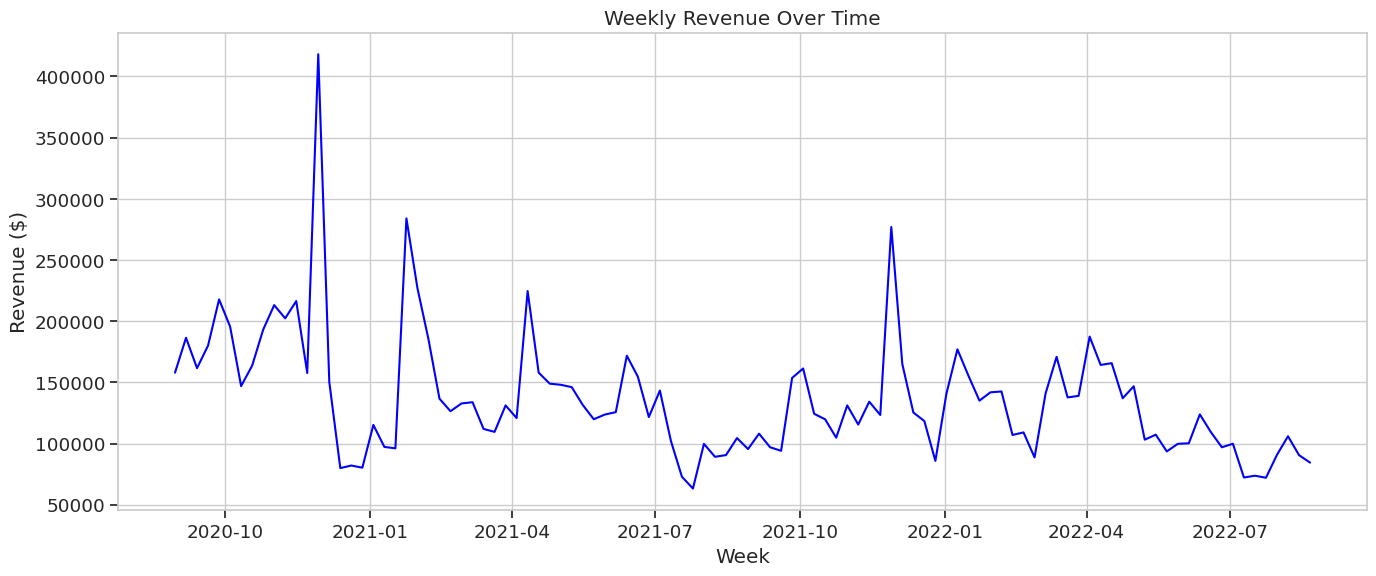

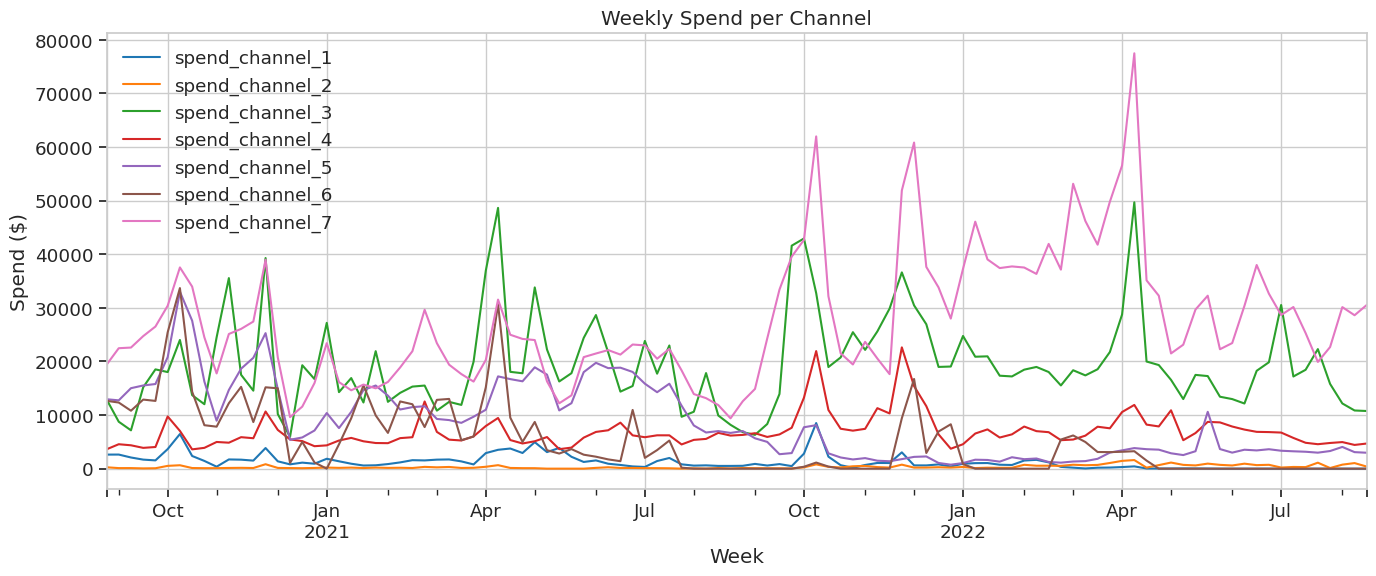

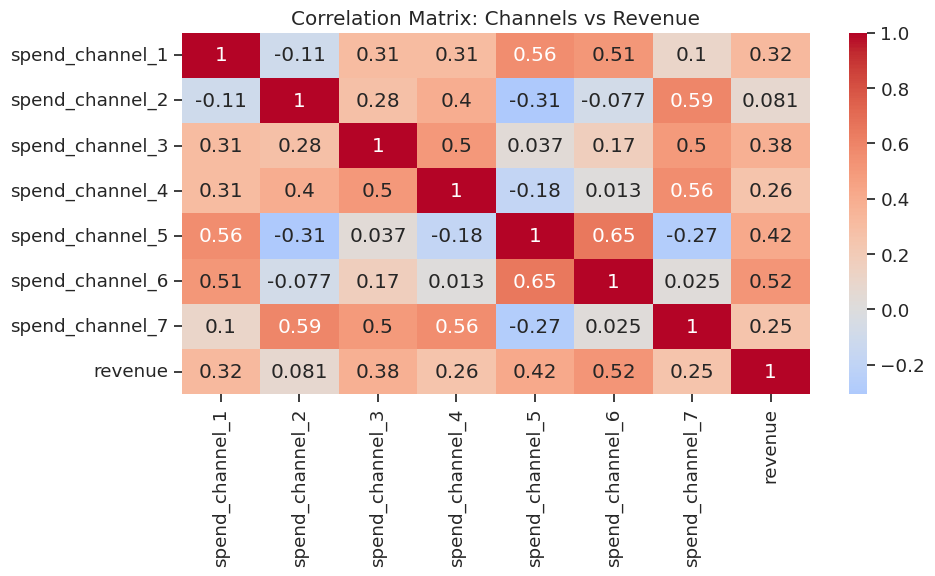


--- 2-4. MODEL DESIGN & PRIOR SELECTION ---

--- 3. ADSTOCK MODELING ---


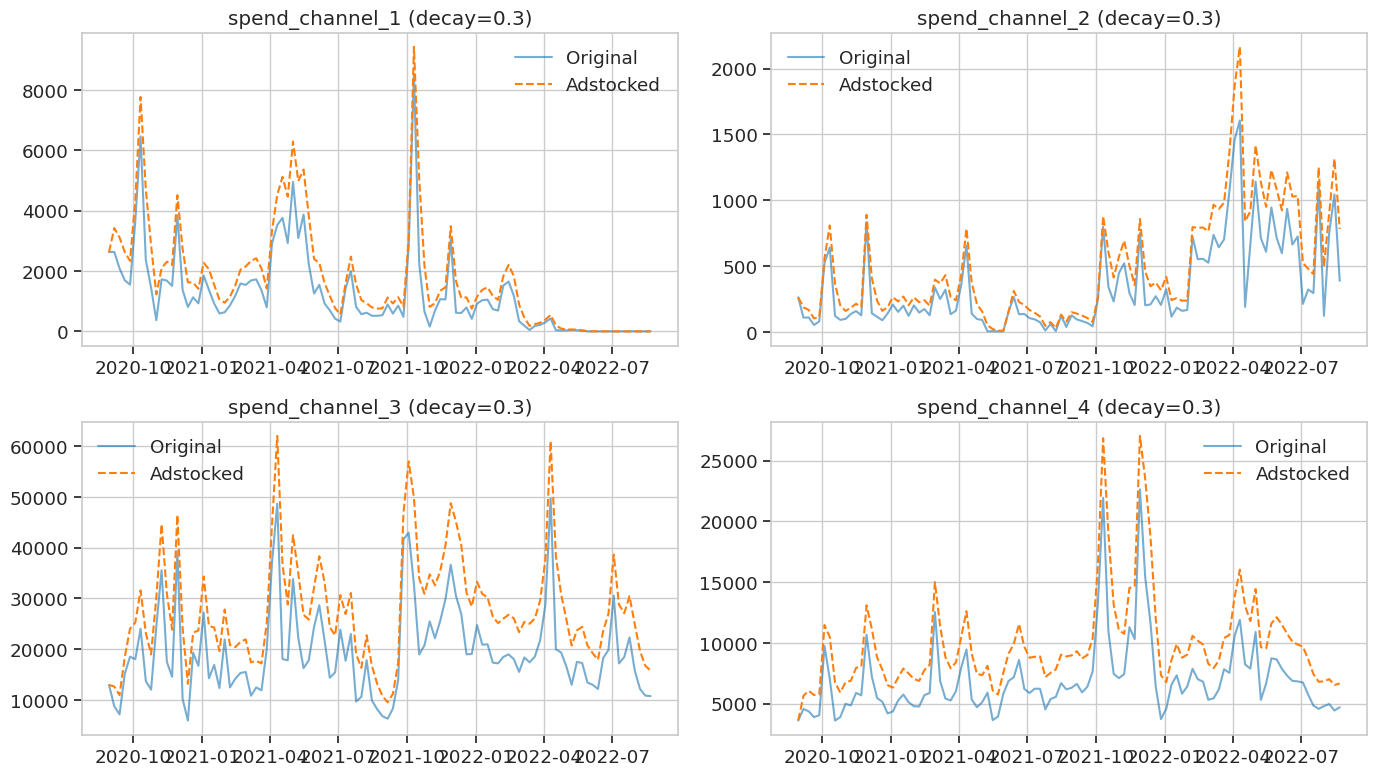


--- 5. MODEL FITTING ---


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [channel_coefs, intercept, trend_coef, season_coefs, sigma]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 8 seconds.



Model Parameter Summary:
                       mean         sd     hdi_3%    hdi_97%  mcse_mean  \
intercept         58697.598  12545.346  34980.108  82255.362    309.360   
trend_coef           -0.019      5.098     -9.600      9.508      0.099   
season_coefs[0]       0.021      4.883     -8.662      9.478      0.092   
season_coefs[1]       0.009      5.034     -9.096      9.831      0.093   
season_coefs[2]      -0.065      5.032     -9.109      9.796      0.101   
season_coefs[3]      -0.088      4.988     -9.418      9.016      0.091   
channel_coefs[0]      1.381      1.221      0.000      3.627      0.024   
channel_coefs[1]      3.698      2.849      0.003      8.914      0.058   
channel_coefs[2]      0.939      0.490      0.001      1.752      0.012   
channel_coefs[3]      1.679      1.087      0.002      3.574      0.025   
channel_coefs[4]      1.748      0.727      0.420      3.055      0.021   
channel_coefs[5]      2.247      0.756      0.828      3.630      0.020   

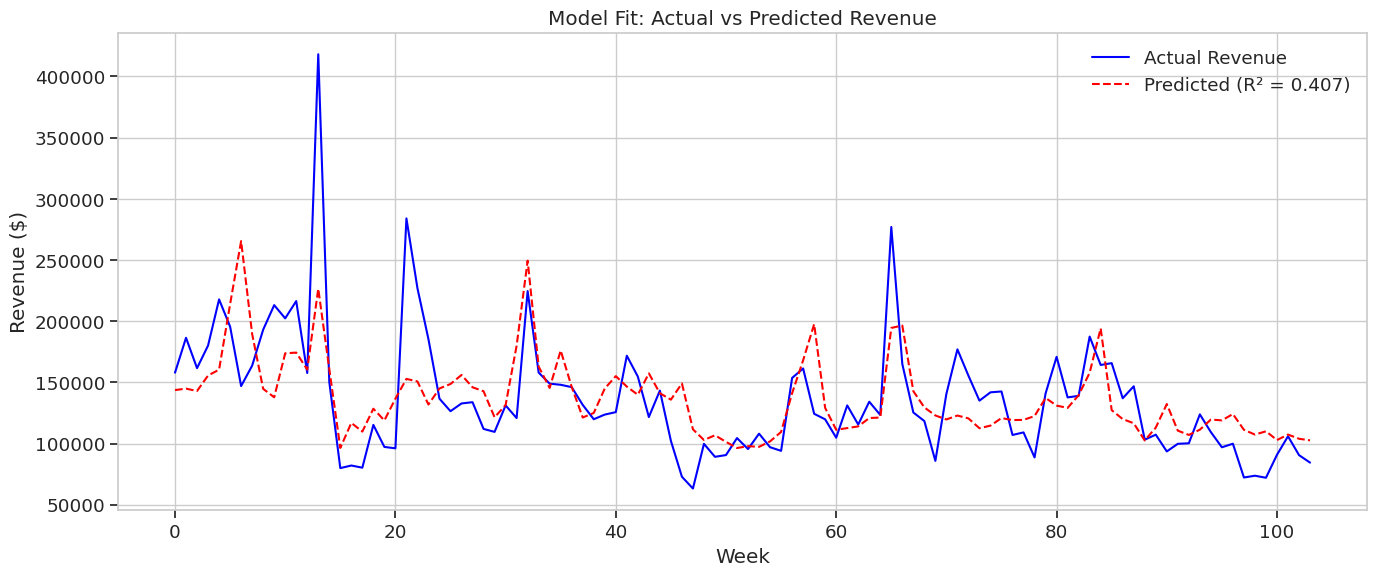

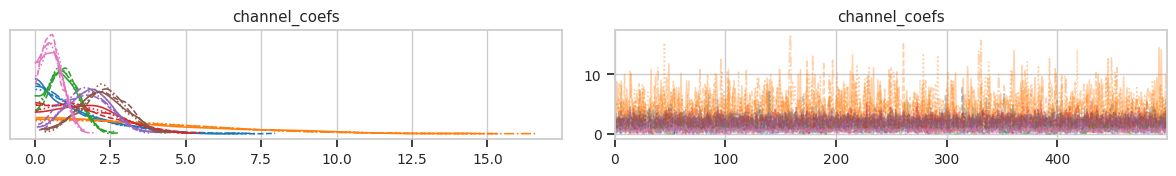


--- 7-8. INSIGHTS & ROI CALCULATION ---

Channel ROI Analysis:
  Channel    Effect  Contribution       Spend       ROI
1       2  3.698410  1.376171e+05    35738.66  3.850652
5       6  2.246576  1.232398e+06   526624.70  2.340183
4       5  1.748185  1.623881e+06   891863.59  1.820773
3       4  1.679467  1.257814e+06   719174.22  1.748970
0       1  1.380809  1.863271e+05   129542.90  1.438343
2       3  0.939014  1.983958e+06  2028746.51  0.977923
6       7  0.571473  1.714224e+06  2880942.21  0.595022


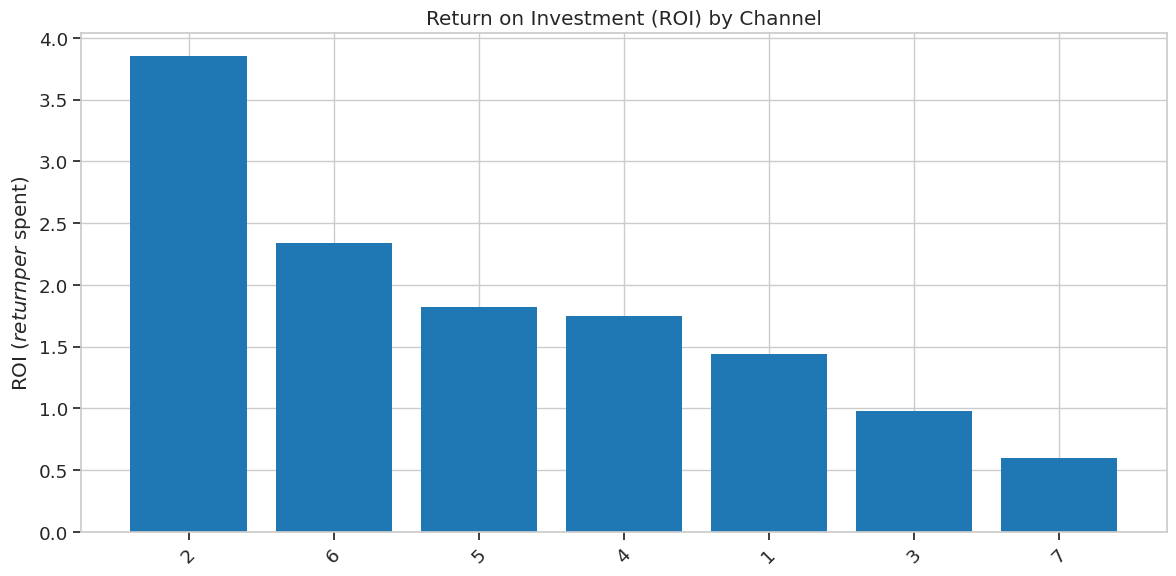

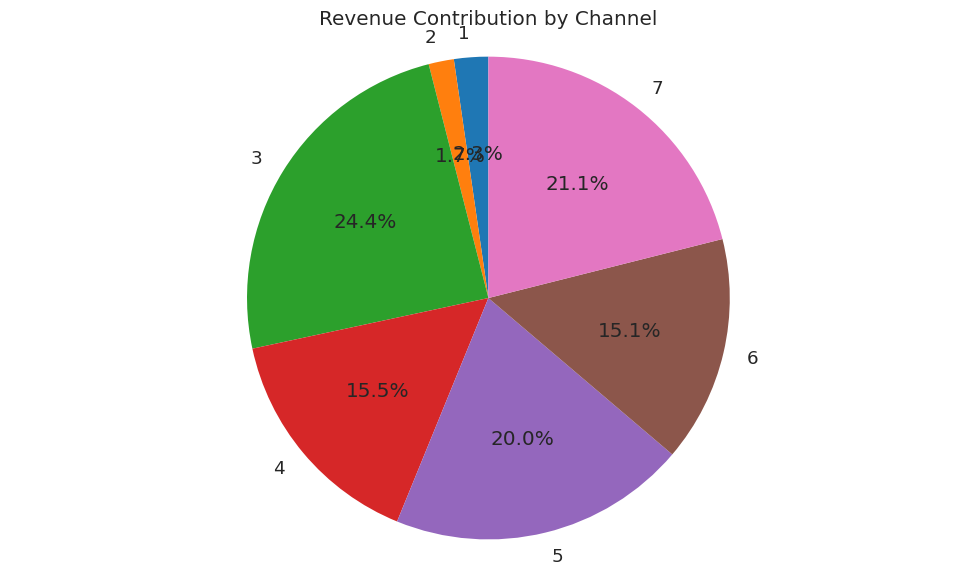


Model R-squared: 0.4071

Analysis Complete!


In [8]:
# ------------------------------------------
# Main execution function
# ------------------------------------------

def run_bayesian_mmm(data_path='MMM_test_data.csv'):
    """Execute the entire Marketing Mix Modeling workflow."""
    print("\n--- 1. DATA EXPLORATION ---")
    data, channel_cols = explore_data(data_path)
    
    print("\n--- 2-4. MODEL DESIGN & PRIOR SELECTION ---")
    X, y, time_scaled, seasons = prepare_model_data(data, channel_cols)
    
    print("\n--- 3. ADSTOCK MODELING ---")
    visualize_adstock(data, channel_cols)
    
    print("\n--- 5. MODEL FITTING ---")
    decay_rate = 0.04
    model, adstocked_data = build_bayesian_mmm(X, y, time_scaled, seasons, channel_cols, decay_rate)
    trace = fit_model(model)
    
    print("\n--- 6. MODEL EVALUATION ---")
    r_squared, y_pred = evaluate_model(trace, y, time_scaled, seasons, adstocked_data, channel_cols)
    
    print("\n--- 7-8. INSIGHTS & ROI CALCULATION ---")
    roi_analysis = analyze_channel_performance(trace, data, channel_cols, adstocked_data)
    
    print(f"\nModel R-squared: {r_squared:.4f}")
    print("\nAnalysis Complete!")

if __name__ == "__main__":
    run_bayesian_mmm()